# Spatial Cross validation
* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [2]:
import pandas as pd
import os
import rasterio
import geopandas as gpd
import spacv
import matplotlib.pyplot as plt
import numpy as np
import random

from shapely import wkt
from shapely.geometry.point import Point

from IAdeforestation.preprocessing import *
from IAdeforestation.spatial_cross_val import *

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
vietnam = gpd.read_file("district/diaphanhuyen.shp")

In [154]:
def display_cross_val_map_class(data_train, data_val, maps, title, xlim=[106,110], ylim=[10,16],legend_labels=["Coffee", "Other"] ,figsize=(12,6)):
    fig, axes = plt.subplots(1,2,figsize=figsize)

    maps.plot(ax=axes[0],facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)
    maps.plot(ax=axes[1],facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)

    data_train[data_train['label'] == 0].plot(ax=axes[0], markersize=1,categorical=True, legend=True, c="tab:green")
    data_val[data_val['label'] == 0].plot(ax=axes[0], markersize=1,categorical=True, legend=True, c="tab:orange")
    
    data_train[data_train['label'] == 1].plot(ax=axes[1], markersize=1,categorical=True, legend=True, c="tab:pink")
    data_val[data_val['label'] == 1].plot(ax=axes[1], markersize=1,categorical=True, legend=True, c="tab:blue")

    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)

    axes[0].set_xlabel("Latitude")
    axes[0].set_ylabel("Longitude")
    
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)

    axes[1].set_xlabel("Latitude")
    axes[1].set_ylabel("Longitude")

    legend = axes[0].legend(legend_labels)
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]
    
    legend = axes[1].legend(legend_labels)
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]

    fig.suptitle(title)

# Shapefile import

In [2]:
LABELS_PATH = 'labels'
SHAPEFILES_PATHS = [os.path.join(LABELS_PATH, 'central_highlands_1_other', 'central_highlands_1_other.shp'),
 os.path.join(LABELS_PATH, 'central_highlands_2_test', 'central_highlands_2_test.shp'),
 os.path.join(LABELS_PATH, 'central_highlands_2_other', 'central_highlands_2_other.shp')]

SHAPEFILE_ESPG=4326

points = process_shapefile(SHAPEFILES_PATHS)

In [3]:
coords, labels = zip(*points)

In [4]:
coords_points = []
plt.show
for p in coords:
    coords_points.append(Point(p[0],p[1]))

In [6]:
geo_df = gpd.GeoDataFrame({'geometry':coords_points, 'labels':labels})

In [7]:
geo_df

,geometry,labels
0,POINT (107.94103 14.43993),6
1,POINT (107.93873 14.44076),6
2,POINT (107.94177 14.43879),6
3,POINT (107.94323 14.43819),6
4,POINT (107.94079 14.43759),6
...,...,...
10264,POINT (107.89111 11.55182),17
10265,POINT (107.89070 11.55158),17
10266,POINT (107.89042 11.55184),17
10267,POINT (107.89034 11.55139),17


# Shapefile on Vietnam map

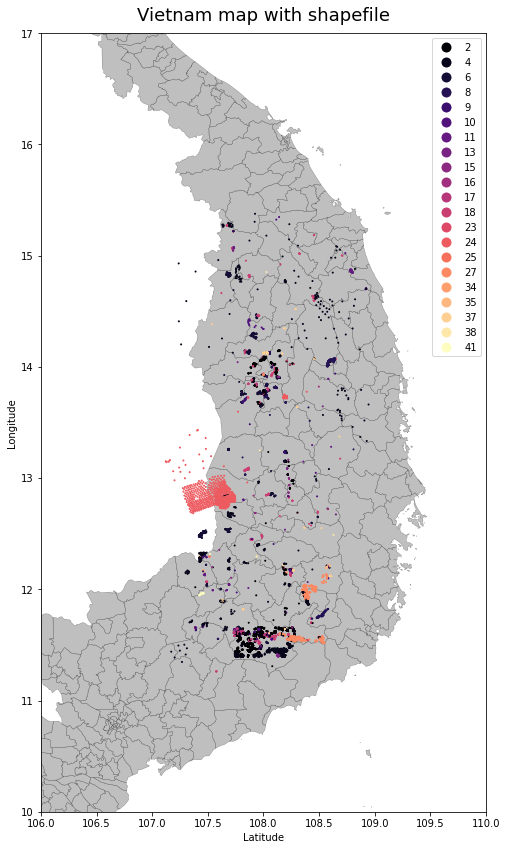

In [8]:
fig, ax = plt.subplots(figsize=(12,12))

vietnam.plot(ax=ax,facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)
geo_df.plot(ax=ax, markersize=1,categorical=True, legend=True, column="labels", cmap="magma")
ax.set_ylim([10,17])
ax.set_xlim([106,110])
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
fig.suptitle("Vietnam map with shapefile", fontsize=18)
fig.tight_layout()

# Spatial train / validation / test split - Classic version
## Split train / test

In [ ]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_all.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)

In [ ]:
skcv = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(all_data['geometry'])

labels = {}
fold_i = 0

for train, validation in skcv:
    geo_train = geo_df.iloc[train]
    geo_val = geo_df.iloc[validation]
    
    tr_0 = len(geo_train[geo_train['label']==2])
    tr_1 = len(geo_train[geo_train['label']!=2])
    
    va_0 = len(geo_val[geo_val['label']==2])
    va_1 = len(geo_val[geo_val['label']!=2])
    
    print(f"train 0 : {tr_0/(tr_0+tr_1)}")
    print(f"train 1 : {tr_1/(tr_0+tr_1)}")
    
    print(f"test 0 : {va_0/(va_0+va_1)}")
    print(f"test 1 : {va_1/(va_0+va_1)}")
    print("----------")
    
    labels[fold_i] = [train, validation]
    
    fold_i+=1

## Save on disk

In [ ]:
data_train = geo_df.iloc[labels[1][0]]
data_test = geo_df.iloc[labels[1][1]]

data_train.to_csv(os.path.join(SAVED_DATASET_PATH, "spring_train.csv"), index=False)
data_test.to_csv(os.path.join(SAVED_DATASET_PATH, "spring_testcsv"), index=False)

## Reload data

In [9]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'spring_train.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'spring_test.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### View fold on map

Fold 1 Number coffee - train : 225
Fold 1 Number no-coffee - train : 771
Fold 1 Number coffee - val : 63
Fold 1 Number no-coffee - val : 295
-----
Fold 2 Number coffee - train : 378
Fold 2 Number no-coffee - train : 1034
Fold 2 Number coffee - val : 19
Fold 2 Number no-coffee - val : 111
-----
Fold 3 Number coffee - train : 391
Fold 3 Number no-coffee - train : 920
Fold 3 Number coffee - val : 5
Fold 3 Number no-coffee - val : 218
-----
Fold 4 Number coffee - train : 375
Fold 4 Number no-coffee - train : 823
Fold 4 Number coffee - val : 20
Fold 4 Number no-coffee - val : 322
-----
Fold 5 Number coffee - train : 81
Fold 5 Number no-coffee - train : 868
Fold 5 Number coffee - val : 290
Fold 5 Number no-coffee - val : 199
-----
Number coffee - test : 101
Number no-coffee - test : 418
-----


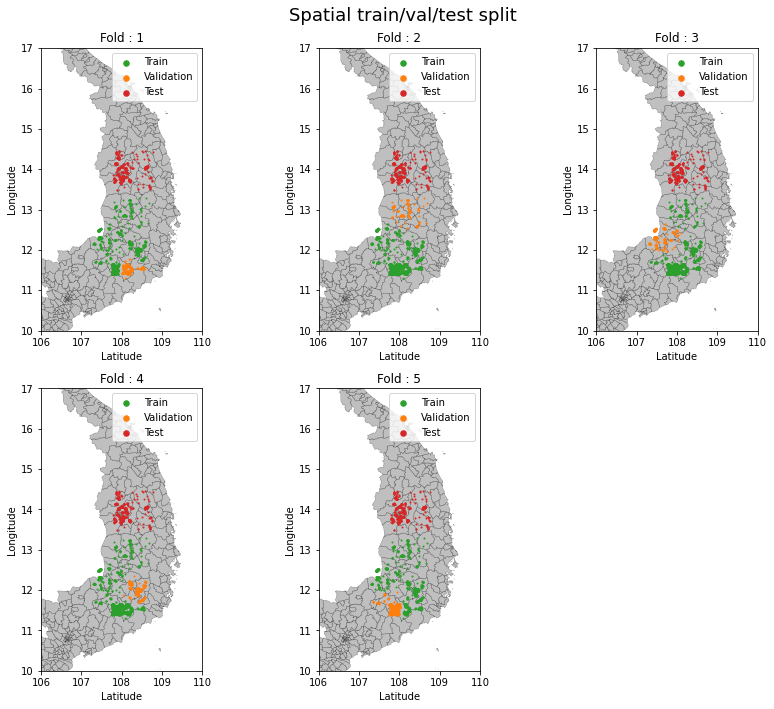

In [10]:
skcv = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(data_train['geometry'])
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=3)

axes = axes.flatten()

i = 0

for train, validation in skcv:
    ax = axes[i]
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    print(f"Fold {i+1} Number coffee - train : {len(geo_train[geo_train['label'] == 2])}")
    print(f"Fold {i+1} Number no-coffee - train : {len(geo_train[geo_train['label'] != 2])}")

    print(f"Fold {i+1} Number coffee - val : {len(geo_val[geo_val['label'] == 2])}")
    print(f"Fold {i+1} Number no-coffee - val : {len(geo_val[geo_val['label'] != 2])}")
    print("-----")
    
    vietnam.plot(ax=ax,facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)

    
    geo_train.plot(ax=ax, markersize=1,categorical=True, legend=True, c="tab:green")
    geo_val.plot(ax=ax, markersize=1,categorical=True, legend=True, c="tab:orange")
    data_test.plot(ax=ax,markersize=1,categorical=True, legend=True, c="tab:red")

    ax.set_ylim([10,17])
    ax.set_xlim([106,110])
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Longitude")
    ax.set_title(f"Fold : {i+1}")
    fig.suptitle("Spatial train/val/test split", fontsize=18)
    legend = ax.legend(["Train", "Validation", "Test"])
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]
    legend.legendHandles[2]._sizes = [30]

    fig.tight_layout()
    i+=1
    
fig.delaxes(ax= axes[-1]) 
print(f"Number coffee - test : {len(data_test[data_test['label'] == 2])}")
print(f"Number no-coffee - test : {len(data_test[data_test['label'] != 2])}")
print("-----")

# Coffee repartition on map

In [7]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_all.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)

all_data.loc[all_data['label'] != 2, 'label'] = 1
all_data.loc[all_data['label'] == 2, 'label'] = 0

coffee_data = all_data[all_data['label'] == 0].reset_index(drop=True)
other_data = all_data[all_data['label'] == 1].reset_index(drop=True)

Fold 1 Number coffee - train : 397
Fold 1 Number no-coffee - train : 1109
Fold 1 Number coffee - val : 101
Fold 1 Number no-coffee - val : 444
-----
Fold 2 Number coffee - train : 266
Fold 2 Number no-coffee - train : 1145
Fold 2 Number coffee - val : 146
Fold 2 Number no-coffee - val : 418
-----
Fold 3 Number coffee - train : 479
Fold 3 Number no-coffee - train : 1319
Fold 3 Number coffee - val : 19
Fold 3 Number no-coffee - val : 231
-----
Fold 4 Number coffee - train : 206
Fold 4 Number no-coffee - train : 1203
Fold 4 Number coffee - val : 211
Fold 4 Number no-coffee - val : 359
-----
Fold 5 Number coffee - train : 473
Fold 5 Number no-coffee - train : 1452
Fold 5 Number coffee - val : 21
Fold 5 Number no-coffee - val : 111
-----


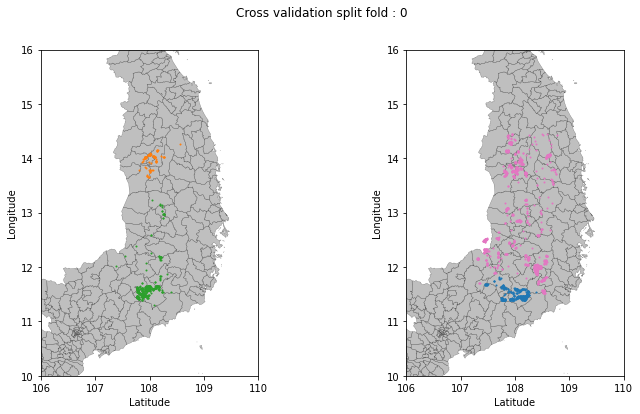

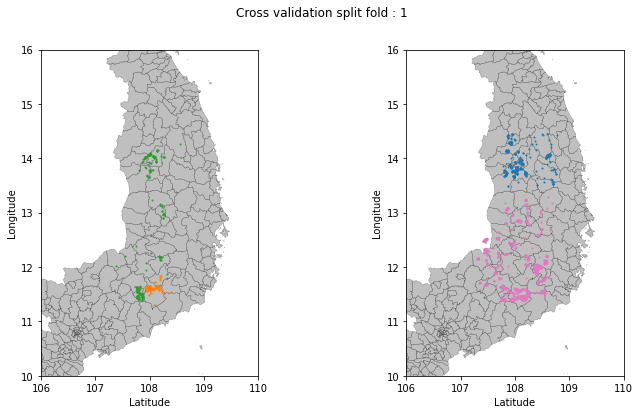

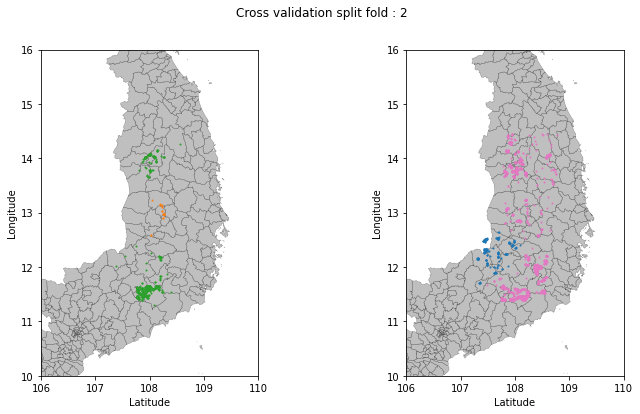

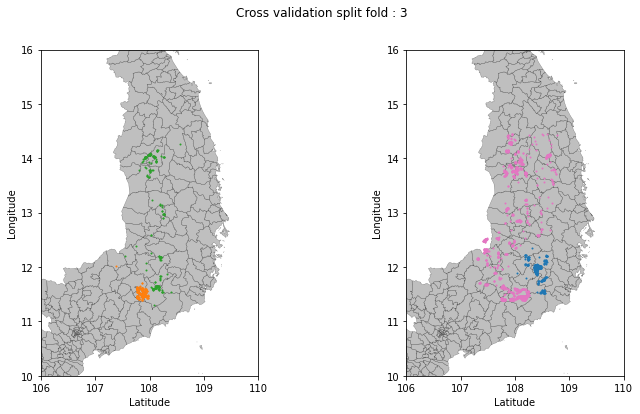

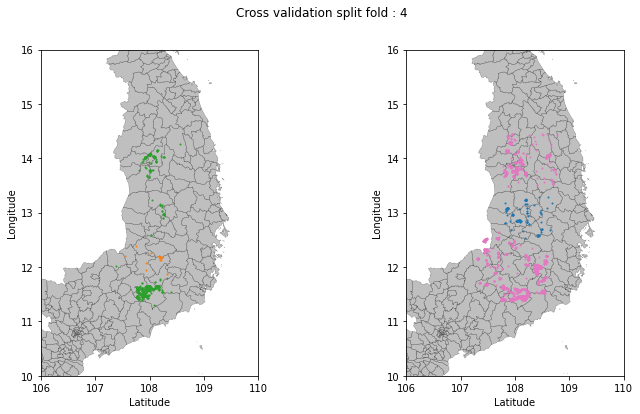

In [8]:
skcv_coffee = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(other_data['geometry'])

i = 0

for coffee, other in zip(skcv_coffee, skcv_other):

    geo_train = coffee_data.iloc[coffee[0]].append(other_data.iloc[other[0]], ignore_index=True)
    geo_val = coffee_data.iloc[coffee[1]].append(other_data.iloc[other[1]], ignore_index=True)
    

    print(f"Fold {i+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print("-----")

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {i}")
    i+=1

## Discussion
This example allows us to see that the number of coffee fields from one fold to another can be very different.

# Coffee vs other train / validation / test split - 10 Fold version
## Train / test split

In [91]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_all.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)

all_data.loc[all_data['label'] != 2, 'label'] = 1
all_data.loc[all_data['label'] == 2, 'label'] = 0

coffee_data = all_data[all_data['label'] == 0].reset_index(drop=True)
other_data = all_data[all_data['label'] == 1].reset_index(drop=True)

In [92]:
NB_FOLD = 10
skcv_coffee = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(other_data['geometry'])
list_fold = []
i = 0

for coffee, other in zip(skcv_coffee, skcv_other):  
    list_fold.append({"train_coffee":coffee[0], "train_other":other[0], "val_coffee":coffee[1], "val_other":other[1]})
    i+=1

In [93]:
list_fold = np.array(list_fold)
np.random.shuffle(list_fold)

Fold 1 Number coffee - train : 417
Fold 1 Number no-coffee - train : 1375
Fold 1 Number coffee - val : 81
Fold 1 Number no-coffee - val : 188
0.8694808345463367
0.13051916545366327
-----
Fold 2 Number coffee - train : 474
Fold 2 Number no-coffee - train : 1215
Fold 2 Number coffee - val : 24
Fold 2 Number no-coffee - val : 348
0.8195050946142649
0.1804949053857351
-----
Fold 3 Number coffee - train : 410
Fold 3 Number no-coffee - train : 1250
Fold 3 Number coffee - val : 88
Fold 3 Number no-coffee - val : 313
0.8054342552159146
0.1945657447840854
-----
Fold 4 Number coffee - train : 362
Fold 4 Number no-coffee - train : 1308
Fold 4 Number coffee - val : 136
Fold 4 Number no-coffee - val : 255
0.8102862688015526
0.18971373119844737
-----
Fold 5 Number coffee - train : 329
Fold 5 Number no-coffee - train : 1104
Fold 5 Number coffee - val : 169
Fold 5 Number no-coffee - val : 459
0.6952935468219311
0.3047064531780689
-----


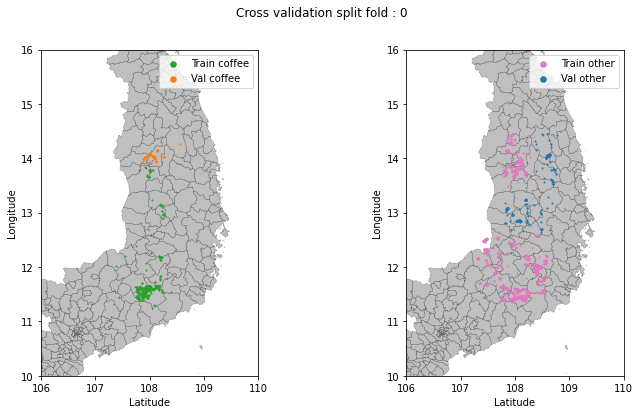

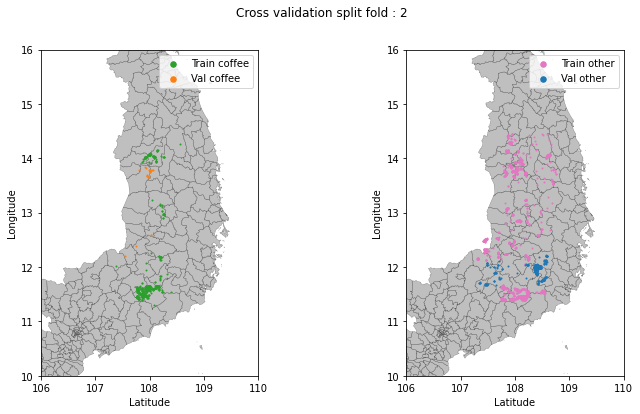

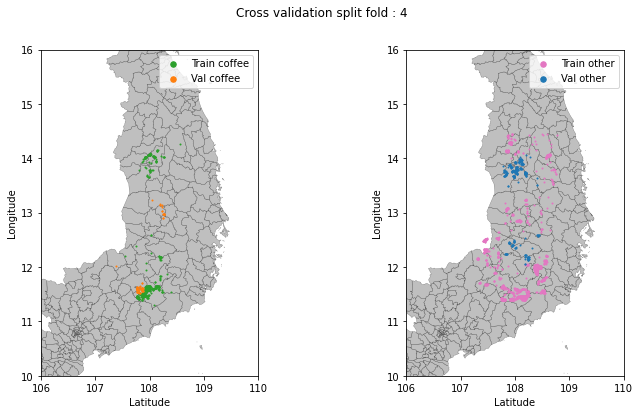

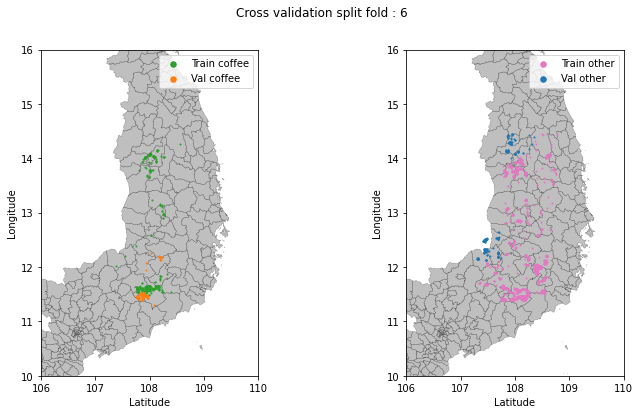

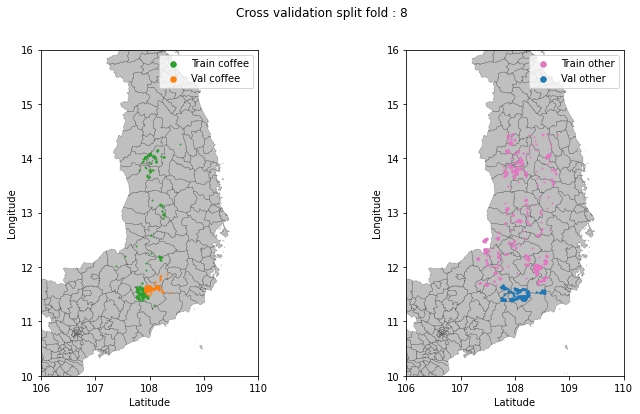

In [94]:
saved_folds = []

for i_fold in range(0, len(list_fold), 2):
    current_indexs = [i_fold, i_fold+1]
    other_indexs = list(set(range(0,10)) - set(current_indexs))
    
    val_coffee = []
    val_other = []
    for l in list_fold[current_indexs]:
        val_coffee.extend(l['val_coffee'])
        val_other.extend(l['val_other'])
        
    train_coffee = []
    train_other = []
    for l in list_fold[other_indexs]:
        train_coffee.extend(l['val_coffee'])
        train_other.extend(l['val_other'])
    
    geo_train = coffee_data.iloc[train_coffee].append(other_data.iloc[train_other], ignore_index=True)
    geo_val = coffee_data.iloc[val_coffee].append(other_data.iloc[val_other], ignore_index=True)
    
    saved_folds.append({'geo_train':geo_train, 'geo_val':geo_val})
    
    index = (i_fold//2)+1
    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {index}")


    print(f"Fold {index} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {index} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {index} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {index} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    
    print(len(geo_train)/(len(geo_train)+len(geo_val)))
    print(len(geo_val)/(len(geo_train)+len(geo_val)))
    print("-----")

In [100]:
saved_folds[2]['geo_train'].to_csv(os.path.join('datasets','coffee_10fold', 'train_data.csv'), index=False)
saved_folds[2]['geo_val'].to_csv(os.path.join('datasets','coffee_10fold', 'test_data.csv'), index=False)

In [147]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','coffee_10fold', 'train_data.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','coffee_10fold', 'test_data.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

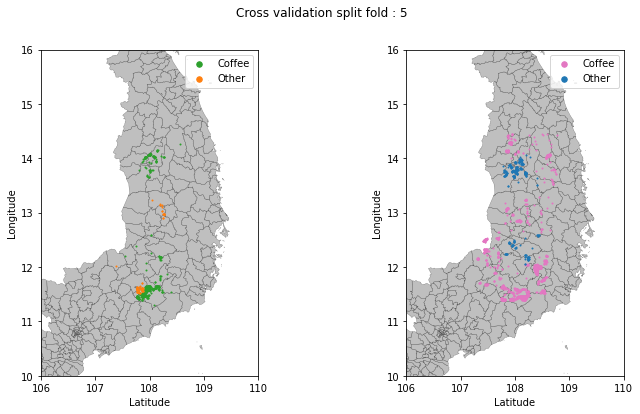

In [118]:
display_cross_val_map_class(data_train, data_test, vietnam, f"Cross validation split fold : {index}")

In [119]:
set_tr = set(data_train['path'].to_numpy())
set_te = set(data_test['path'].to_numpy())
print(f"{len(set_tr.intersection(set_te))} images of the training set in test set and vice versa")

0 images of the training set in test set and vice versa


## Run same algorithm on train set to get train /validation fold

In [151]:
coffee_data = data_train[data_train['label'] == 0].reset_index(drop=True)
other_data = data_train[data_train['label'] == 1].reset_index(drop=True)

In [152]:
NB_FOLD = 10
skcv_coffee = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(other_data['geometry'])
list_fold = []
i = 0

for coffee, other in zip(skcv_coffee, skcv_other):  
    list_fold.append({"train_coffee":coffee[0], "train_other":other[0], "val_coffee":coffee[1], "val_other":other[1]})
    i+=1
    
list_fold = np.array(list_fold)
np.random.shuffle(list_fold)

Fold 1 Number coffee - train : 316
Fold 1 Number no-coffee - train : 1063
Fold 1 Number coffee - val : 94
Fold 1 Number no-coffee - val : 187
0.8307228915662651
0.16927710843373495
-----
Fold 2 Number coffee - train : 374
Fold 2 Number no-coffee - train : 930
Fold 2 Number coffee - val : 36
Fold 2 Number no-coffee - val : 320
0.7855421686746988
0.21445783132530122
-----
Fold 3 Number coffee - train : 292
Fold 3 Number no-coffee - train : 1059
Fold 3 Number coffee - val : 118
Fold 3 Number no-coffee - val : 191
0.813855421686747
0.186144578313253
-----
Fold 4 Number coffee - train : 284
Fold 4 Number no-coffee - train : 810
Fold 4 Number coffee - val : 126
Fold 4 Number no-coffee - val : 440
0.6590361445783133
0.3409638554216867
-----
Fold 5 Number coffee - train : 374
Fold 5 Number no-coffee - train : 1138
Fold 5 Number coffee - val : 36
Fold 5 Number no-coffee - val : 112
0.9108433734939759
0.0891566265060241
-----


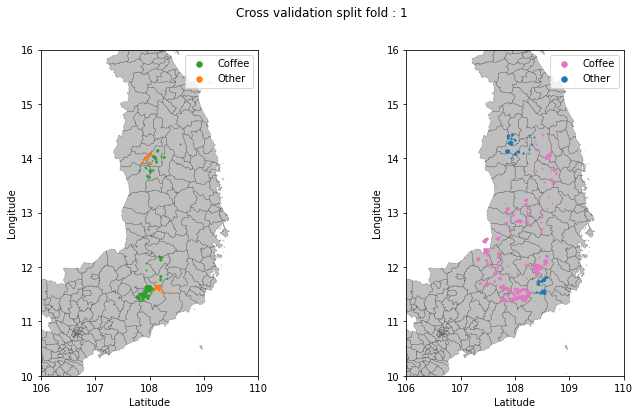

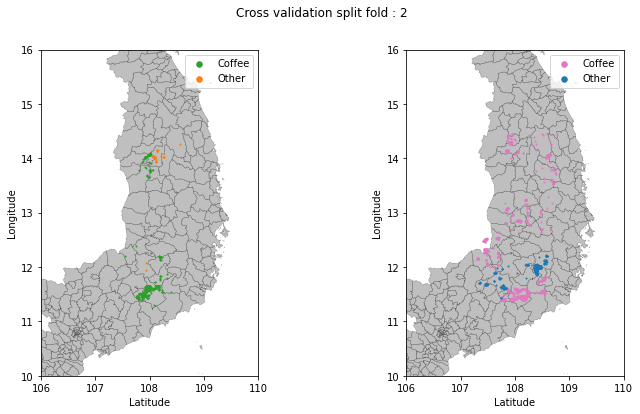

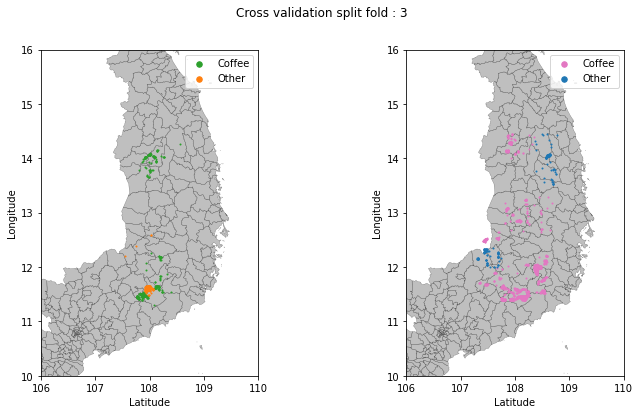

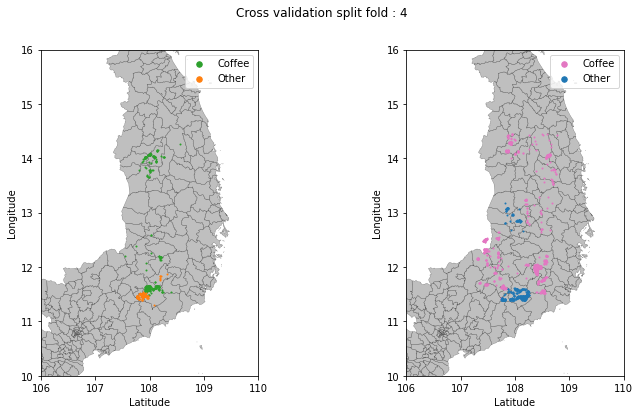

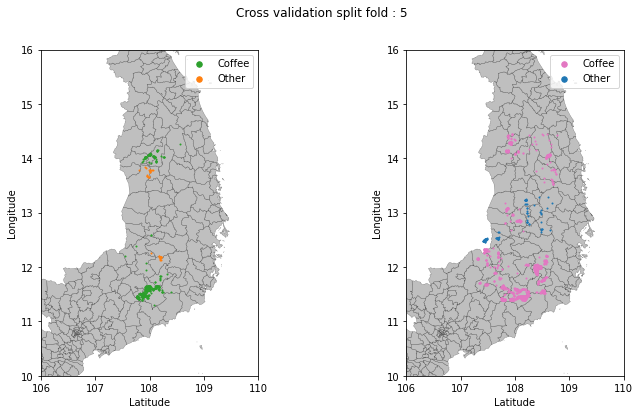

In [153]:
for i_fold in range(0, len(list_fold), 2):
    current_indexs = [i_fold, i_fold+1]
    other_indexs = list(set(range(0,10)) - set(current_indexs))
    
    val_coffee = []
    val_other = []
    for l in list_fold[current_indexs]:
        val_coffee.extend(l['val_coffee'])
        val_other.extend(l['val_other'])
        
    train_coffee = []
    train_other = []
    for l in list_fold[other_indexs]:
        train_coffee.extend(l['val_coffee'])
        train_other.extend(l['val_other'])
    
    geo_train = coffee_data.iloc[train_coffee].append(other_data.iloc[train_other], ignore_index=True)
    geo_val = coffee_data.iloc[val_coffee].append(other_data.iloc[val_other], ignore_index=True)
        
    index = (i_fold//2)+1
    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {index}")


    print(f"Fold {index} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {index} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {index} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {index} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    
    print(len(geo_train)/(len(geo_train)+len(geo_val)))
    print(len(geo_val)/(len(geo_train)+len(geo_val)))
    
    geo_train.to_csv(os.path.join("datasets", "coffee_10fold", f"train_{index}_data.csv"), index=False)
    geo_val.to_csv(os.path.join("datasets", "coffee_10fold", f"val_{index}_data.csv"), index=False)
    print("-----")

In [116]:
train_fold1 =  gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','coffee_10fold', f'train_{1}_data.csv')))
val_fold1 = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets','coffee_10fold', f'val_{1}_data.csv')))

set_tr = set(train_fold1['path'].to_numpy())
set_val = set(val_fold1['path'].to_numpy())
print(f"{len(set_tr.intersection(set_val))} images of the training set in validation set and vice versa")

set_tr = set_tr.union(set_val)
set_te = set(data_test['path'].to_numpy())
print(f"{len(set_tr.intersection(set_te))} images of the training set in validation set and vice versa")

0 images of the training set in validation set and vice versa
0 images of the training set in validation set and vice versa


# Culture vs other train / validation / test split - 10 Fold version
## Train / test split

In [51]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'culture_10fold','train_data.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)

'''culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree
all_data = all_data[all_data['label'].isin(culture_list + no_culture_list)].reset_index()

all_data.loc[all_data['label'].isin(culture_list), 'label'] = 0
all_data.loc[all_data['label'].isin(no_culture_list), 'label'] =1'''

culture_data = all_data[all_data['label'] == 0].reset_index(drop=True)
no_culture_data = all_data[all_data['label'] == 1].reset_index(drop=True)

In [52]:
NB_FOLD = 10
skcv_coffee = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(culture_data['geometry'])
skcv_other = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(no_culture_data['geometry'])
list_fold = []
i = 0

for coffee, other in zip(skcv_coffee, skcv_other):  
    list_fold.append({"train_culture":coffee[0], "train_no_culture":other[0], "val_culture":coffee[1], "val_no_culture":other[1]})

In [53]:
random.shuffle(list_fold)

In [54]:
selected_fold = []

0.9469072164948453
0.05309278350515464
Fold 1 Number coffee - train : 2724
Fold 1 Number no-coffee - train : 2787
Fold 1 Number coffee - val : 138
Fold 1 Number no-coffee - val : 171
-----
0.9475622588565416
0.052437741143458436
Fold 2 Number coffee - train : 2558
Fold 2 Number no-coffee - train : 2845
Fold 2 Number coffee - val : 194
Fold 2 Number no-coffee - val : 105
-----
0.8678038379530917
0.13219616204690832
Fold 3 Number coffee - train : 2298
Fold 3 Number no-coffee - train : 2586
Fold 3 Number coffee - val : 474
Fold 3 Number no-coffee - val : 270
-----
0.9160621761658031
0.08393782383419689
Fold 4 Number coffee - train : 2554
Fold 4 Number no-coffee - train : 2750
Fold 4 Number coffee - val : 286
Fold 4 Number no-coffee - val : 200
-----
0.8098866052445074
0.19011339475549255
Fold 5 Number coffee - train : 2420
Fold 5 Number no-coffee - train : 2151
Fold 5 Number coffee - val : 340
Fold 5 Number no-coffee - val : 733
-----


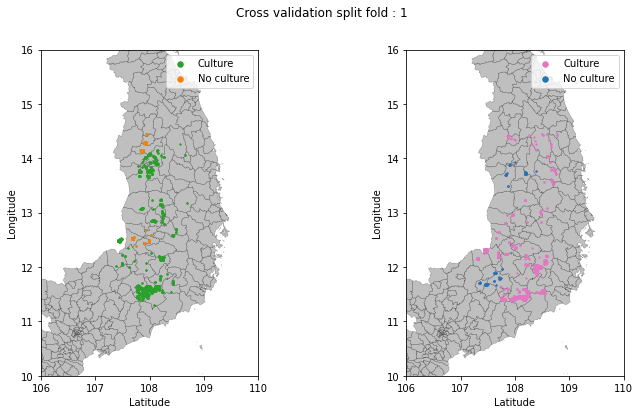

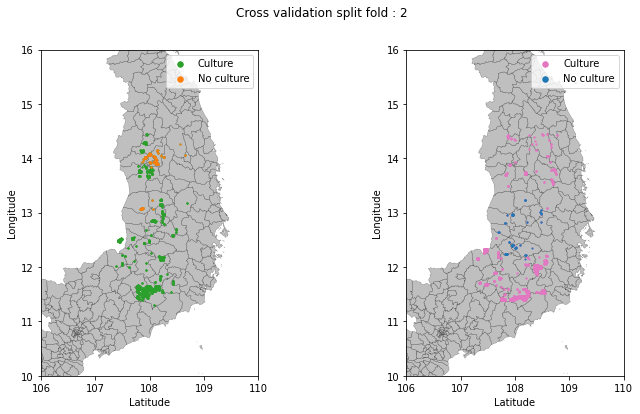

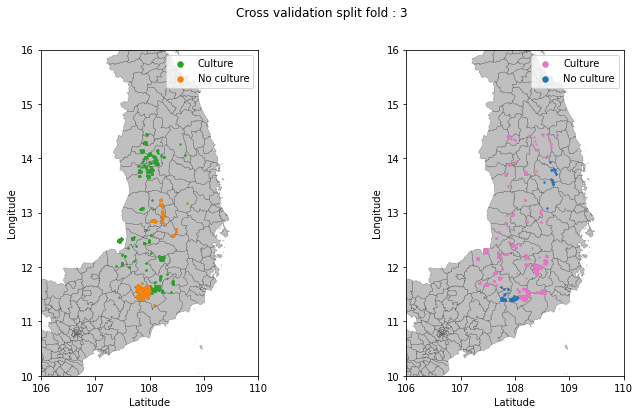

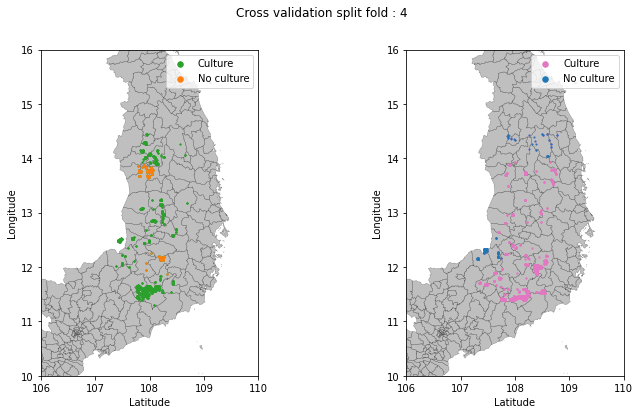

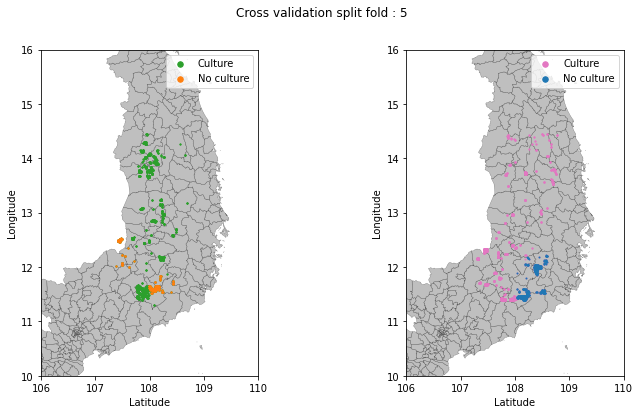

In [55]:
for i_fold in range(0, len(list_fold), 2):
    
    first_fold = list_fold[i_fold]
    second_fold = list_fold[i_fold+1]
    
    train_culture = np.concatenate([first_fold["train_culture"], second_fold["train_culture"]])
    val_culture = np.concatenate([first_fold["val_culture"], second_fold["val_culture"]])
    train_no_culture = np.concatenate([first_fold["train_no_culture"], second_fold["train_no_culture"]])
    val_no_culture = np.concatenate([first_fold["val_no_culture"], second_fold["val_no_culture"]])
    
    geo_train = culture_data.iloc[train_culture].append(no_culture_data.iloc[train_no_culture], ignore_index=True)
    geo_val = culture_data.iloc[val_culture].append(no_culture_data.iloc[val_no_culture], ignore_index=True)
    
    print(len(geo_train)/(len(geo_train)+len(geo_val)))
    print(len(geo_val)/(len(geo_train)+len(geo_val)))
    
    index = (i_fold//2)+1
    geo_train.to_csv(os.path.join("datasets", "culture_10fold", f"train_{index}_data.csv"), index=False)
    geo_val.to_csv(os.path.join("datasets", "culture_10fold", f"val_{index}_data.csv"), index=False)
    
    print(f"Fold {index} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {index} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {index} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {index} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print("-----")

    display_cross_val_map_class(geo_train, geo_val, vietnam,  f"Cross validation split fold : {index}",legend_labels=["Culture", "No culture"])


In [16]:
selected_fold[2]['geo_train'].to_csv(os.path.join('datasets', 'culture_10fold','data_train.csv'), index=False)
selected_fold[2]['geo_val'].to_csv(os.path.join('datasets', 'culture_10fold','data_test.csv'), index=False)

# Stratified Spatial Cross val

In [217]:
train_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_train.csv')))
train_data['geometry'] = train_data['geometry'].apply(wkt.loads)

train_data.loc[train_data['label'] != 2, 'label'] = 1
train_data.loc[train_data['label'] == 2, 'label'] = 0

test_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_test.csv')))
test_data['geometry'] = test_data['geometry'].apply(wkt.loads)

test_data.loc[test_data['label'] != 2, 'label'] = 1
test_data.loc[test_data['label'] == 2, 'label'] = 0

In [220]:
nb_labels = train_data['label'].value_counts().to_dict()
prop0 = nb_labels[0]/(nb_labels[0]+nb_labels[1])
prop1 = nb_labels[1]/(nb_labels[0]+nb_labels[1])

print(prop0)
print(prop1)

0.25745784695201035
0.7425421530479897


In [221]:
nb_labels

{1: 1145, 0: 397}

In [222]:
def compute_mean_point(df):
    coord_x = []
    coord_y = []
    
    for p in df['geometry'].to_numpy():
        coord_x.append(p.x)
        coord_y.append(p.y)
        
    return (np.mean(coord_x), np.mean(coord_y))

In [223]:
def find_nearest_points(mean_point, df_points, nb_to_draw):
    dict_points = {}
    for p in df_points.iterrows():
        current_point = p[1]['geometry']
        dict_points[p[0]] = np.sqrt((mean_point[0] - current_point.x) ** 2 + (mean_point[1] - current_point.y) ** 2)
        
    sorted_dict = dict(sorted(dict_points.items(), key=lambda item: item[1]))
    return list(sorted_dict)[0:nb_to_draw]

In [257]:
def stratified_df(geo_train, geo_val, nb_labels, nb_fold=5):
    
    prop0 = nb_labels[0]/nb_fold
    prop1 = nb_labels[1]/nb_fold
    
    nb_train0 = len(geo_train[geo_train['label'] ==0])
    nb_val0 = len(geo_val[geo_val['label'] ==0])

    
    mean_train = compute_mean_point(geo_train)
    mean_val = compute_mean_point(geo_val)
    
    if np.abs(nb_val0 - prop0) < 5 :
        pass
    else:
        if nb_val0 < prop0:
            print('nb_val0 < prop0')
            nb_to_draw = int(prop0 - nb_val0)
            
            index_to_switch = find_nearest_points(mean_val, geo_train[geo_train['label'] == 0], nb_to_draw)
            rows = geo_train.loc[index_to_switch]
            geo_train = geo_train.drop(index_to_switch, inplace=False, axis='index')
            
            geo_val = geo_val.append(rows, ignore_index=True)
        else :

            nb_to_draw = int(nb_val0 - prop0)
            
            index_to_switch = find_nearest_points(mean_train, geo_val[geo_val['label'] == 0], nb_to_draw)
            rows = geo_val.loc[index_to_switch]
            geo_val = geo_val.drop(index_to_switch, inplace=False, axis='index')
            
            geo_train = geo_train.append(rows, ignore_index=True)
            
    nb_train1 = len(geo_train[geo_train['label'] ==1])
    nb_val1 = len(geo_val[geo_val['label'] ==1])

    if np.abs(nb_val1 - prop1) < 5 :
        pass
    else:
        if nb_val1 < prop1:
            nb_to_draw = int(prop1 - nb_val1)
            
            index_to_switch = find_nearest_points(mean_val, geo_train[geo_train['label'] ==1], nb_to_draw)
            rows = geo_train.loc[index_to_switch]
            geo_train = geo_train.drop(index_to_switch, inplace=False, axis='index')
            
            geo_val = geo_val.append(rows, ignore_index=True)
        else :
            nb_to_draw = int(nb_val1 - prop1)
            
            index_to_switch = find_nearest_points(mean_train, geo_val[geo_val['label'] == 1], nb_to_draw)
            rows = geo_val.loc[index_to_switch]
            geo_val = geo_val.drop(index_to_switch, inplace=False, axis='index')
            
            geo_train = geo_train.append(rows, ignore_index=True)
                             
    return (geo_train, geo_val)

nb_val0 < prop0
317
909
0.25856443719412725
0.7414355628058727
79
229
0.2564935064935065
0.7435064935064936
-------
288
837
0.256
0.744
80
229
0.2588996763754045
0.7411003236245954
-------
nb_val0 < prop0
317
916
0.2570965125709651
0.7429034874290349
79
229
0.2564935064935065
0.7435064935064936
-------
nb_val0 < prop0
318
916
0.2576985413290113
0.7423014586709886
79
229
0.2564935064935065
0.7435064935064936
-------
nb_val0 < prop0
225
833
0.21266540642722118
0.7873345935727788
79
229
0.2564935064935065
0.7435064935064936
-------


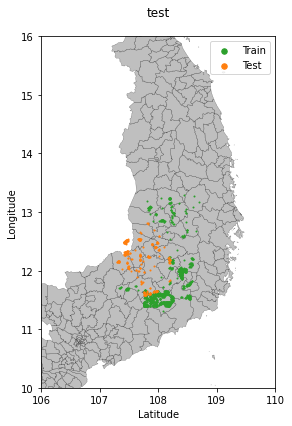

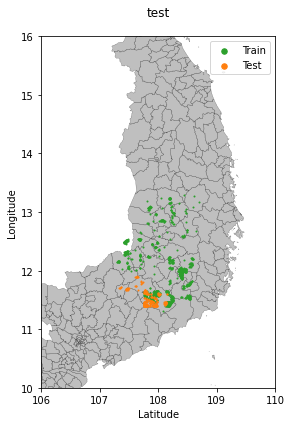

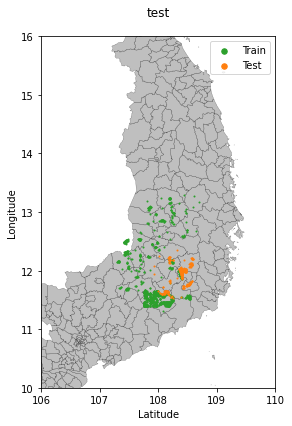

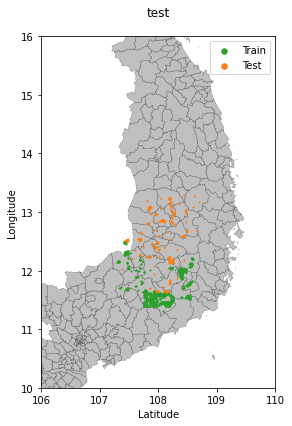

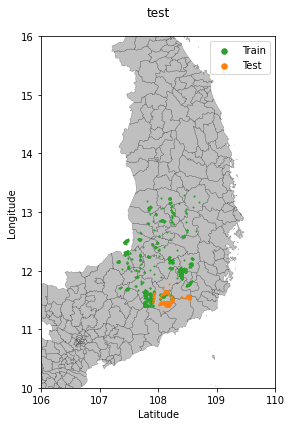

In [258]:
NB_FOLD = 5

skcv = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(train_data['geometry'])

fold_index = 0

results = []

for train, validation in skcv:
    geo_train = train_data.iloc[train]
    geo_val = train_data.iloc[validation]

    
    geo_train, geo_val = stratified_df(geo_train, geo_val, nb_labels, NB_FOLD)
    
    len0 = len(geo_train[geo_train['label'] ==0])
    len1 = len(geo_train[geo_train['label'] ==1])
    print(len0)
    print(len1)
    print(len0/(len0+len1))
    print(len1/(len0+len1))

    
    len0 = len(geo_val[geo_val['label'] ==0])
    len1 = len(geo_val[geo_val['label'] ==1])
    print(len0)
    print(len1)
    print(len0/(len0+len1))
    print(len1/(len0+len1))
    print("-------")
    
    
    display_cross_val_map(geo_train, geo_val, vietnam, "test")